[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ai2es/WAF_ML_Tutorial_Part1/blob/main/MOOC_Notebooks/Notebook03_TrainValTest.ipynb)

# Notebook 03: TrainValTest [MOOC Colab Version]

Authors: Randy J. Chase, David R. Harrison, Amanda Burke, Gary M. Lackmann, and Amy McGovern<br>
Institution: [AI2ES](https://www.ai2es.org)<br>
Associated paper: [A Machine Learning Tutorial for Operational Meteorology. Part I: Traditional Machine Learning](https://journals.ametsoc.org/view/journals/wefo/37/8/WAF-D-22-0070.1.xml)<br>
Original Github: [WAF_ML_Tutorial_Part1](https://github.com/ai2es/WAF_ML_Tutorial_Part1)

If you use this code or data in your work, please cite the paper: 

Chase, R. J., Harrison, D. R., Burke, A., Lackmann, G. M., & McGovern, A. (2022). A Machine Learning Tutorial for Operational Meteorology. Part I: Traditional Machine Learning, Weather and Forecasting, 37(8), 1509-1529.

### Goal: Understand how to do train/val/test splitting

#### Background

In the paper, Section 3.b, we discuss the importance of separating the total dataset into ```train```, ```validation``` and ```test``` subsets. Please go re-read this section if it is not clear to you why we do this.

#### Step 0: Get the github repo (we need some of the functions there)

The first step with all of these Google Colab notebooks will be to grab the github repo and cd into the notebooks directory. 

To run things from the command line, put a ```!``` before your code




In [1]:
#get the github repo 
!git clone https://github.com/ai2es/WAF_ML_Tutorial_Part1.git 

#cd into the repo so the paths work 
import os 
os.chdir('/content/WAF_ML_Tutorial_Part1/jupyter_notebooks/')

Cloning into 'WAF_ML_Tutorial_Part1'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (301/301), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 301 (delta 139), reused 236 (delta 96), pack-reused 0
Receiving objects: 100% (301/301), 195.77 MiB | 16.15 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Checking out files: 100% (100/100), done.


#### Step 1: Import packages and load data.  
This is basically the same steps as the last notebooks, but this time we load the same dataframe as the previous notebook.

In [2]:
#needed packages 
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

#plot parameters that I personally like, feel free to make these your own.
import matplotlib
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'

#load an example dataframe
df = pd.read_csv('../datasets/sevir/IR_stats_master.csv',index_col=0,low_memory=False,parse_dates=True)
#scale back to correct units
keys = list(df.keys()[:-1])
df[keys] = df[keys]*1e-2
#remove outlier
df = df.where(df.q000 > -100)
#make sure index is in order
df = df.sort_index()
# df = df.dropna()

df.head()

,q000,q001,q010,q025,q050,q075,q090,q099,q100,event
2018-02-04 16:40:00,-61.31,-59.45,-55.30,-52.59,-47.00,-36.92,-26.560,-4.4163,15.19,Thunderstorm Wind
2018-02-04 16:45:00,-61.90,-59.13,-55.37,-52.52,-47.68,-38.00,-26.753,-6.9400,15.32,Thunderstorm Wind
2018-02-04 16:50:00,-61.16,-58.93,-55.35,-52.55,-48.17,-39.07,-27.013,-8.8400,15.62,Thunderstorm Wind
2018-02-04 16:55:00,-61.63,-58.87,-55.38,-52.68,-48.34,-40.16,-27.030,-8.9163,14.27,Thunderstorm Wind
2018-02-04 17:00:00,-61.67,-58.82,-55.42,-52.81,-48.38,-40.75,-27.240,-9.0526,6.57,Thunderstorm Wind


#### Step 2: Temporal Split

For meteorological data it is often good to use time to split up your data. The way we have build these datasets (i.e., dataframes), encoding time as ```datetimes``` and ```pandas``` makes time selection really simple. For example, maybe we wanted to subset all data from August 2018. We can do that like the following: 

In [3]:
time_range = slice('2018-08-01','2018-09-01')
df_august = df[time_range]

df_august.index.min(),df_august.index.max()

(Timestamp('2018-08-01 00:00:00'), Timestamp('2018-09-01 23:55:00'))

This is really quite a powerful tool, we can do fun things like, show the distribution of minimum infrared brightness temperature on a monthly basis. 

To actually do this, we will use the ```groupby``` method, that will help us group all the data by their month. 

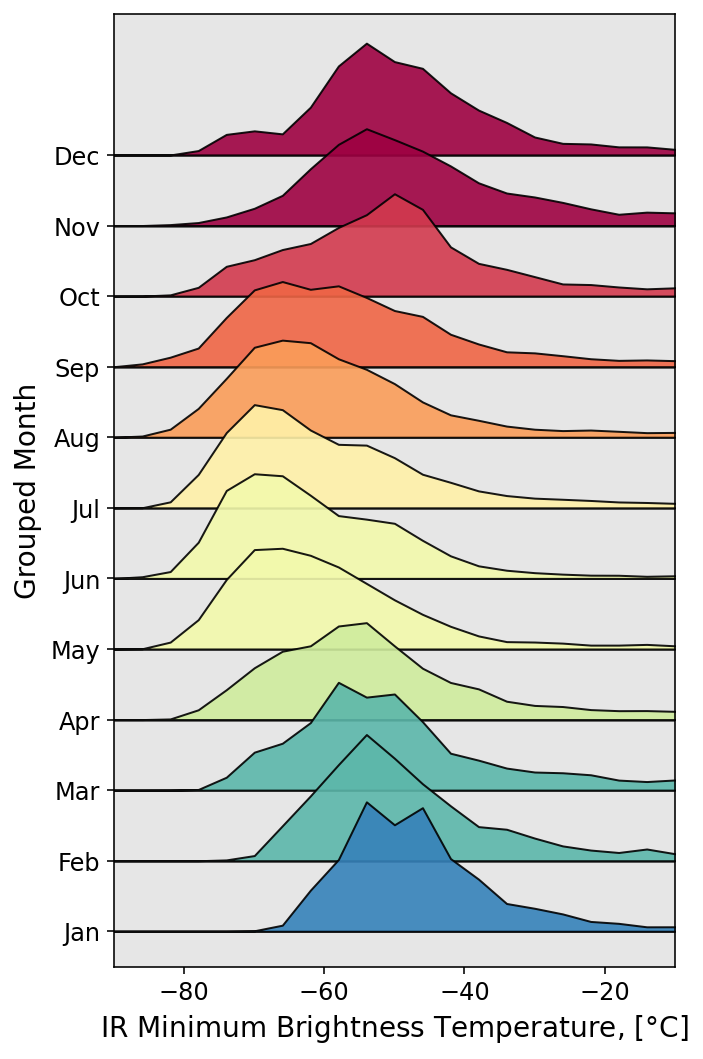

In [6]:
#this is in order Jan, Feb, Mar ...
groups = df.q000.groupby(df.index.month)

#for plotting purposes I want to reverse that 
groups = list(groups)
groups = groups[::-1]

###### plot stuff #########
bins=np.arange(-100,0,4)
#midpoints of the bins
mids=np.arange(-98,-2,4)
#colormap to assign a color for each month 
cmap = matplotlib.cm.Spectral_r
bounds = np.arange(0,1.3,.1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
scalarMap = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
###########################

###### Actual Plot #########
#make fig
fig = plt.figure(figsize=(5,7.5))
#set not clear facecolor
fig.set_facecolor('w')
#grab axis handle 
ax = plt.gca()
#loop over all groups 
for idx,group in groups:
    #get the counts per bin 
    c,b = np.histogram(group.values,bins=bins)
    #normalize 
    c = c/c.sum()
    #plot axis line
    ax.axhline((idx/10),color='k',zorder=0,alpha=0.5)
    #plot curve
    ax.fill_between(mids,(idx/10),c+(idx/10),alpha=0.9,facecolor=scalarMap.to_rgba((idx/10)),edgecolor='k')

#set plot xlimits
ax.set_xlim([-90,-10])
#force ticks to show up for each group
ax.set_yticks(np.arange(0,1.3,.1))
#force ylimits
ax.set_ylim([0.05,1.4])
#force yticklabels
ax.set_yticklabels(['','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
#add axis labels
ax.set_xlabel('IR Minimum Brightness Temperature, [$\degree$C]')
ax.set_ylabel('Grouped Month')

plt.tight_layout()

As expected, we can see that the summer months have colder cloud tips in their images. Which should correspond to stronger storms! Now, lets follow suit with how the data were split in the paper: 

training: 2017-01-01 through 2019-06-01 </br>
val & test, randomly chunk up the rest:: 2019-06-01 through 2019-12-31


In [7]:
#make training time slice
train_time_range = slice('2017-01-01','2019-06-01')
#make training dataframe
df_train = df[train_time_range]

#put the val/test data into one dataframe
other_time_range = slice('2019-06-01','2019-12-31')
df_other = df[other_time_range]

#make list of indices 
idx = np.arange(0,df_other.shape[0])
#set random seed for reproducability 
np.random.seed(seed=42)
#grab random indices for the val and use the rest for test 
idx_v = np.random.choice(idx,size=int(idx.shape[0]/2),replace=False)
#sort it because the randomness puts them out of time order
idx_v.sort()
idx_t = np.setdiff1d(idx,idx_v)


df_validation = df_other.iloc[idx_v]
df_test = df_other.iloc[idx_t]

Let's take a look at their shapes to make sure the val & test are the same

In [8]:
df_validation.shape[0],df_test.shape[0]

(86338, 86338)

#### Step 3: Random Split

There are times where a pure random split can be used. In those instances, you can use a pre-built function in scikit-learn to do this for you. The first step though, is to convert our input dataframe to a simple numpy matrix of shape, (n_samples,n_features). This matrix is commonly denoted as ```X``` on the scikit website. We also need out output data (i.e., labels), which are commonly denoted as ```y``` which is the shape (n_samples) on scikit's website.

In [9]:
from sklearn.model_selection import train_test_split

############  make simple X ###############
#drop the event column, we dont need that 
df_noevent = df.drop(columns='event')
#make simple numpy matrix of our inputs, X
X = df_noevent.to_numpy()
###########################################


############  make simple y ###############
#load the label matrix, the number of GLM flashes
df_label = pd.read_csv('../datasets/sevir/LI_stats_master.csv',index_col=0,low_memory=False,parse_dates=True)
#make simple numpy vector of the outputs, y
y = df_label.c.values
###########################################


#if we wanted to do a random split, we could use this function 
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.33, random_state=42)

#seeing as there is no specific validation dataset, we must further split validation and test 
X_validation, X_test, y_validation, y_test = train_test_split(X_other, y_other, test_size=0.5, random_state=42)

#check shapes
X_train.shape,X_validation.shape,X_test.shape

((414872, 9), (102170, 9), (102171, 9))

What we have shown you was just for 1 variable (we have 3 others to consider). It takes a bit more effort to do this will all the variables, so I have gone ahead and built this into a function. If you are truly interested, check out the ```load_n_comine_df``` function in the ```aux_functions.py``` script. Below is an example of loading the data into their groups

In [10]:
#import some helper functions for our other directory.
import sys
sys.path.insert(1, '../scripts/')
from aux_functions import load_n_combine_df
(X_train,y_train),(X_validate,y_validate),(X_test,y_test) = load_n_combine_df(path_to_data='../datasets/sevir/',features_to_keep=np.arange(0,36,1),class_labels=True)

In [11]:
#check shapes
X_train.shape,X_validation.shape,X_test.shape

((446307, 36), (102170, 9), (86296, 36))